## Setup du Notebook

In [1]:
import ezc3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import ID #import des fonctions spécifiques au notebook
from scipy.signal import find_peaks

In [2]:
def readMotionFile(filename):

    if not os.path.exists(filename):
        print('file do not exists')

    file_id = open(filename, 'r')

    # read header
    next_line = file_id.readline()
    header = [next_line]
    nc = 0
    nr = 0
    while not 'endheader' in next_line:
        if 'datacolumns' in next_line:
            nc = int(next_line[next_line.index(' ') + 1:len(next_line)])
        elif 'datarows' in next_line:
            nr = int(next_line[next_line.index(' ') + 1:len(next_line)])
    
        elif 'nColumns' in next_line:
            nc = int(next_line[next_line.index('=') + 1:len(next_line)])
        elif 'nRows' in next_line:
            nr = int(next_line[next_line.index('=') + 1:len(next_line)])

        next_line = file_id.readline()
        header.append(next_line)

    # process column labels
    next_line = file_id.readline()
    if next_line.isspace() == True:
        next_line = file_id.readline()

    labels = next_line.split()

    # get data
    data = []
    for i in range(1, nr + 1):
        d = [float(x) for x in file_id.readline().split()]
        data.append(d)

    file_id.close()

    return header, labels, data

In [3]:
def find_index(name,list):
    return list.index(name)

In [4]:
def analyse_angle(data):
    [h,l,d]=readMotionFile(data)

    #Création des conteneurs
    knee_flexion_l=np.zeros(len(d))
    knee_flexion_r=np.zeros(len(d))

    hip_flexion_r=np.zeros(len(d))
    hip_flexion_l=np.zeros(len(d))

    hip_adduction_r=np.zeros(len(d))
    hip_adduction_l=np.zeros(len(d))

    hip_rotation_r=np.zeros(len(d))
    hip_rotation_l=np.zeros(len(d))

    ankle_flexion_r=np.zeros(len(d))
    ankle_flexion_l=np.zeros(len(d))

    time=np.zeros(len(d))

    for i in range(len(d)):
        time[i]=d[i][0]
        knee_flexion_r[i]=d[i][find_index("knee_angle_r",l)]
        knee_flexion_l[i]=d[i][find_index("knee_angle_l",l)]

        hip_flexion_r[i]=d[i][find_index("hip_flexion_r",l)]
        hip_flexion_l[i]=d[i][find_index("hip_flexion_l",l)]

        hip_adduction_r[i]=d[i][find_index("hip_adduction_r",l)]
        hip_adduction_l[i]=d[i][find_index("hip_adduction_l",l)]

        hip_rotation_r[i]=d[i][find_index("hip_rotation_r",l)]
        hip_rotation_l[i]=d[i][find_index("hip_rotation_l",l)]

        ankle_flexion_r[i]=d[i][find_index("ankle_angle_r",l)]
        ankle_flexion_l[i]=d[i][find_index("ankle_angle_l",l)]    

    return knee_flexion_r,knee_flexion_l,hip_flexion_r,hip_flexion_l,hip_adduction_r,hip_adduction_l,hip_rotation_r,hip_rotation_l,ankle_flexion_r,ankle_flexion_l

In [5]:
def amplitude_cycle_Xsens(c3dFiles, motFiles, segment):
    articulations = {
        "knee_flexion_r": analyse_angle(motFiles)[0],
        "knee_flexion_l": analyse_angle(motFiles)[1],
        "hip_flexion_r": analyse_angle(motFiles)[2],
        "hip_flexion_l": analyse_angle(motFiles)[3],
        "hip_adduction_r": analyse_angle(motFiles)[4],
        "hip_adduction_l": analyse_angle(motFiles)[5],
        "hip_rotation_r": analyse_angle(motFiles)[6],
        "hip_rotation_l": analyse_angle(motFiles)[7],
        "ankle_flexion_r": analyse_angle(motFiles)[8],
        "ankle_flexion_l": analyse_angle(motFiles)[9]
    }
    
    c = ezc3d.c3d(c3dFiles, extract_forceplat_data=False)

    point_data = c['data']['points']
    point_labels = c['parameters']['POINT']['LABELS']
    nf_mocap = len(point_data[0][0][:])

    Of = np.zeros((nf_mocap, 3))
    Of[:, 0] = 0.5 * (point_data[0][find_index("pRightMedMalleolus", point_labels["value"])][:] + point_data[0][find_index("pRightLatMalleolus", point_labels["value"])][:])
    Of[:, 1] = 0.5 * (point_data[1][find_index("pRightMedMalleolus", point_labels["value"])][:] + point_data[1][find_index("pRightLatMalleolus", point_labels["value"])][:])
    Of[:, 2] = 0.5 * (point_data[2][find_index("pRightMedMalleolus", point_labels["value"])][:] + point_data[2][find_index("pRightLatMalleolus", point_labels["value"])][:])

    peaks = find_peaks(Of[:, 2], distance=10)
    peaks_to_analyze = peaks[0][:-1][-11:]

    amplitudes = []
    for i in range(len(peaks_to_analyze) - 1):
        start_frame = peaks_to_analyze[i]
        end_frame = peaks_to_analyze[i + 1]
        sub_angulation_data = articulations[segment][start_frame:end_frame + 1]
        amplitude = max(sub_angulation_data) - min(sub_angulation_data)
        amplitudes.append(amplitude)

    return amplitudes


In [6]:
def amplitude_cycle(c3dFiles, motFiles, segment):
    articulations = {
        "knee_flexion_r": analyse_angle(motFiles)[0],
        "knee_flexion_l": analyse_angle(motFiles)[1],
        "hip_flexion_r": analyse_angle(motFiles)[2],
        "hip_flexion_l": analyse_angle(motFiles)[3],
        "hip_adduction_r": analyse_angle(motFiles)[4],
        "hip_adduction_l": analyse_angle(motFiles)[5],
        "hip_rotation_r": analyse_angle(motFiles)[6],
        "hip_rotation_l": analyse_angle(motFiles)[7],
        "ankle_flexion_r": analyse_angle(motFiles)[8],
        "ankle_flexion_l": analyse_angle(motFiles)[9]
    }
    
    c = ezc3d.c3d(c3dFiles, extract_forceplat_data=False)

    point_data = c['data']['points']
    point_labels = c['parameters']['POINT']['LABELS']
    nf_mocap = len(point_data[0][0][:])

    Of = np.zeros((nf_mocap, 3))
    Of[:, 0] = 0.5 * (point_data[0][find_index("RANI", point_labels["value"])][:] + point_data[0][find_index("RANE", point_labels["value"])][:])
    Of[:, 1] = 0.5 * (point_data[1][find_index("RANI", point_labels["value"])][:] + point_data[1][find_index("RANE", point_labels["value"])][:])
    Of[:, 2] = 0.5 * (point_data[2][find_index("RANI", point_labels["value"])][:] + point_data[2][find_index("RANE", point_labels["value"])][:])

    peaks = find_peaks(Of[:, 2], distance=10)
    peaks_to_analyze = peaks[0][:-1][-11:]

    amplitudes = []
    for i in range(len(peaks_to_analyze) - 1):
        start_frame = peaks_to_analyze[i]
        end_frame = peaks_to_analyze[i + 1]
        sub_angulation_data = articulations[segment][start_frame:end_frame + 1]
        amplitude = max(sub_angulation_data) - min(sub_angulation_data)
        amplitudes.append(amplitude)

    return amplitudes

In [7]:
def amplitude_cycle_markerless(trcFiles, motFiles, segment):
    articulations = {
        "knee_flexion_r": analyse_angle(motFiles)[0],
        "knee_flexion_l": analyse_angle(motFiles)[1],
        "hip_flexion_r": analyse_angle(motFiles)[2],
        "hip_flexion_l": analyse_angle(motFiles)[3],
        "hip_adduction_r": analyse_angle(motFiles)[4],
        "hip_adduction_l": analyse_angle(motFiles)[5],
        "hip_rotation_r": analyse_angle(motFiles)[6],
        "hip_rotation_l": analyse_angle(motFiles)[7],
        "ankle_flexion_r": analyse_angle(motFiles)[8],
        "ankle_flexion_l": analyse_angle(motFiles)[9]
    }
    
        # Charger le fichier TRC avec genfromtxt
    data = np.genfromtxt(trcFiles, delimiter='\t', skip_header=5)

    # Lire la ligne des en-têtes
    with open(trcFiles, 'r') as file:
        headers = file.readlines()[3].strip().split('\t')

    # Trouver l'indice de la colonne correspondant à "RAnkle"
    headers_list_cleaned = [item for item in headers if item]

    # Trouver l'indice de la position de "RAnkle"
    col_index = (headers_list_cleaned.index('RAnkle'))-1

    # Accéder aux coordonnées x, y et z de "RAnkle"
    y_coordinates = data[:, col_index * 3 ]  # Colonne pour les coordonnées y de "RAnkle"

    peaks = find_peaks(y_coordinates, distance=10)
    peaks_to_analyze = peaks[0][:-1][-11:]

    amplitudes = []
    for i in range(len(peaks_to_analyze) - 1):
        start_frame = peaks_to_analyze[i]
        end_frame = peaks_to_analyze[i + 1]
        sub_angulation_data = articulations[segment][start_frame:end_frame + 1]
        amplitude = max(sub_angulation_data) - min(sub_angulation_data)
        amplitudes.append(amplitude)

    return amplitudes

In [8]:
## CALCUL AMPLITUDE MARKERLESS
import csv
import os

dossier_sujets = "/Users/mathieubourgeois/Desktop/Analyse_Markerless/Traitement_Markerless"
dossier_peaks = "/Users/mathieubourgeois/Desktop/Analyse/C3DFiles"

contenu_dossier = os.listdir(dossier_sujets)

sujets = [nom for nom in contenu_dossier if os.path.isdir(os.path.join(dossier_sujets, nom))]

# Chemin du fichier CSV pour enregistrer les résultats
chemin_csv = "/Users/mathieubourgeois/Desktop/resultats_amplitude_markerless.csv"

# Ouvrir le fichier CSV en mode écriture
with open(chemin_csv, "w", newline="") as fichier_csv:
    writer = csv.writer(fichier_csv)

    # Écrire l'en-tête du fichier CSV
    en_tete = ["Articulation", "Vitesse velo", "Sujet"] + [f"Amplitude {i+1}" for i in range(10)]
    writer.writerow(en_tete)

    articulations2 = ["knee_flexion_r", "knee_flexion_l", "hip_flexion_r", "hip_flexion_l", "hip_adduction_r", "hip_adduction_l", "hip_rotation_r", "hip_rotation_l", "ankle_flexion_r", "ankle_flexion_l"]

    for articulation in articulations2:
        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_60_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_60.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_80_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_80.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_100_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_100.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

print("Les résultats ont été enregistrés dans le fichier CSV :", chemin_csv)


KeyboardInterrupt: 

In [12]:
## CALCUL AMPLITUDE MARKER

import csv
import os

dossier_sujets = "/Users/mathieubourgeois/Desktop/Analyse/Traitement_marker"
dossier_peaks = "/Users/mathieubourgeois/Desktop/Analyse/C3DFiles"

contenu_dossier = os.listdir(dossier_sujets)

sujets = [nom for nom in contenu_dossier if os.path.isdir(os.path.join(dossier_sujets, nom))]

# Chemin du fichier CSV pour enregistrer les résultats
chemin_csv = "/Users/mathieubourgeois/Desktop/resultats_amplitude_marker.csv"

# Ouvrir le fichier CSV en mode écriture
with open(chemin_csv, "w", newline="") as fichier_csv:
    writer = csv.writer(fichier_csv)

    # Écrire l'en-tête du fichier CSV
    en_tete = ["Articulation", "Vitesse velo", "Sujet"] + [f"Amplitude {i+1}" for i in range(10)]
    writer.writerow(en_tete)

    articulations = ["knee_flexion_r", "knee_flexion_l", "hip_flexion_r", "hip_flexion_l", "hip_adduction_r", "hip_adduction_l", "hip_rotation_r", "hip_rotation_l", "ankle_flexion_r", "ankle_flexion_l"]

    for articulation in articulations:
        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"Transformed_{sujet}_velo_60_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_60.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"Transformed_{sujet}_velo_80_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_80.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"Transformed_{sujet}_velo_100_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_100.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

print("Les résultats ont été enregistrés dans le fichier CSV :", chemin_csv)

Les résultats ont été enregistrés dans le fichier CSV : /Users/mathieubourgeois/Desktop/resultats_amplitude_marker.csv


In [13]:
## CALCUL AMPLITUDE IMU_Xsens
import csv
import os

dossier_sujets = "/Users/mathieubourgeois/Desktop/AnalyseIMU/Traitement_IMU_xsens"
dossier_peaks = "/Users/mathieubourgeois/Desktop/AnalyseIMU/C3DFilesIMU"

contenu_dossier = os.listdir(dossier_sujets)

sujets = [nom for nom in contenu_dossier if os.path.isdir(os.path.join(dossier_sujets, nom))]

# Chemin du fichier CSV pour enregistrer les résultats
chemin_csv = "/Users/mathieubourgeois/Desktop/resultats_amplitude_IMU.csv"

# Ouvrir le fichier CSV en mode écriture
with open(chemin_csv, "w", newline="") as fichier_csv:
    writer = csv.writer(fichier_csv)

    # Écrire l'en-tête du fichier CSV
    en_tete = ["Articulation", "Vitesse velo", "Sujet"] + [f"Amplitude {i+1}" for i in range(10)]
    writer.writerow(en_tete)

    articulations = ["knee_flexion_r", "knee_flexion_l", "hip_flexion_r", "hip_flexion_l", "hip_adduction_r", "hip_adduction_l", "hip_rotation_r", "hip_rotation_l", "ankle_flexion_r", "ankle_flexion_l"]

    for articulation in articulations:
        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"{sujet}_velo_60_Xsens_jointangle_q.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[3]  # Assumer que la valeur velo est la troisième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_60.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_Xsens(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"{sujet}_velo_80_Xsens_jointangle_q.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[3]  # Assumer que la valeur velo est la troisième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_80.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_Xsens(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"{sujet}_velo_100_Xsens_jointangle_q.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[3]  # Assumer que la valeur velo est la troisième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_100.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_Xsens(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

print("Les résultats ont été enregistrés dans le fichier CSV :", chemin_csv)

Les résultats ont été enregistrés dans le fichier CSV : /Users/mathieubourgeois/Desktop/resultats_amplitude_IMU.csv


In [14]:
## CALCUL AMPLITUDE MARKERLESS_NOMARKER
import csv
import os

dossier_sujets = "/Users/mathieubourgeois/Desktop/Analyse_Markerless_nomarker/Traitement_Markerless_nomarker"
dossier_peaks = "/Users/mathieubourgeois/Desktop/Analyse_Markerless_nomarker/Traitement_Markerless_nomarker"

contenu_dossier = os.listdir(dossier_sujets)

sujets = [nom for nom in contenu_dossier if os.path.isdir(os.path.join(dossier_sujets, nom))]

# Chemin du fichier CSV pour enregistrer les résultats
chemin_csv = "/Users/mathieubourgeois/Desktop/resultats_amplitude_markerless_nomarker.csv"

# Ouvrir le fichier CSV en mode écriture
with open(chemin_csv, "w", newline="") as fichier_csv:
    writer = csv.writer(fichier_csv)

    # Écrire l'en-tête du fichier CSV
    en_tete = ["Articulation", "Vitesse velo", "Sujet"] + [f"Amplitude {i+1}" for i in range(10)]
    writer.writerow(en_tete)

    articulations2 = ["knee_flexion_r", "knee_flexion_l", "hip_flexion_r", "hip_flexion_l", "hip_adduction_r", "hip_adduction_l", "hip_rotation_r", "hip_rotation_l", "ankle_flexion_r", "ankle_flexion_l"]

    for articulation in articulations2:
        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_60_nomarkers_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak,"Data", f"OpenSimTheia_{sujet}_velo_60_nomarkers_filt.trc")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_markerless(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_80_nomarkers_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak,"Data", f"OpenSimTheia_{sujet}_velo_80_nomarkers_filt.trc")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_markerless(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_100_nomarkers_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak,"Data", f"OpenSimTheia_{sujet}_velo_100_nomarkers_filt.trc")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_markerless(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

print("Les résultats ont été enregistrés dans le fichier CSV :", chemin_csv)

Les résultats ont été enregistrés dans le fichier CSV : /Users/mathieubourgeois/Desktop/resultats_amplitude_markerless_nomarker.csv


In [15]:
## CALCUL AMPLITUDE MARKERLESS AVEC TRC
import csv
import os

dossier_sujets = "/Users/mathieubourgeois/Desktop/Analyse_Markerless/Traitement_Markerless"
dossier_peaks = "/Users/mathieubourgeois/Desktop/Analyse_Markerless/Traitement_Markerless"

contenu_dossier = os.listdir(dossier_sujets)

sujets = [nom for nom in contenu_dossier if os.path.isdir(os.path.join(dossier_sujets, nom))]

# Chemin du fichier CSV pour enregistrer les résultats
chemin_csv = "/Users/mathieubourgeois/Desktop/resultats_amplitude_markerless.csv"

# Ouvrir le fichier CSV en mode écriture
with open(chemin_csv, "w", newline="") as fichier_csv:
    writer = csv.writer(fichier_csv)

    # Écrire l'en-tête du fichier CSV
    en_tete = ["Articulation", "Vitesse velo", "Sujet"] + [f"Amplitude {i+1}" for i in range(10)]
    writer.writerow(en_tete)

    articulations2 = ["knee_flexion_r", "knee_flexion_l", "hip_flexion_r", "hip_flexion_l", "hip_adduction_r", "hip_adduction_l", "hip_rotation_r", "hip_rotation_l", "ankle_flexion_r", "ankle_flexion_l"]

    for articulation in articulations2:
        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_60_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak,"Data", f"OpenSimTheia_{sujet}_velo_60_filt.trc")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_markerless(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_80_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak,"Data", f"OpenSimTheia_{sujet}_velo_80_filt.trc")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_markerless(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"OpenSimTheia_{sujet}_velo_100_filt_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[4]  # Assumer que la valeur velo est le quatrième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak,"Data", f"OpenSimTheia_{sujet}_velo_100_filt.trc")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_markerless(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

print("Les résultats ont été enregistrés dans le fichier CSV :", chemin_csv)

Les résultats ont été enregistrés dans le fichier CSV : /Users/mathieubourgeois/Desktop/resultats_amplitude_markerless.csv


In [14]:
## CALCUL AMPLITUDE IMU_Opensim
import csv
import os

dossier_sujets = "/Users/mathieubourgeois/Desktop/AnalyseIMU/Traitement_IMU_Opensim"
dossier_peaks = "/Users/mathieubourgeois/Desktop/AnalyseIMU/C3DFilesIMU"

contenu_dossier = os.listdir(dossier_sujets)

sujets = [nom for nom in contenu_dossier if os.path.isdir(os.path.join(dossier_sujets, nom))]

# Chemin du fichier CSV pour enregistrer les résultats
chemin_csv = "/Users/mathieubourgeois/Desktop/resultats_amplitude_IMU_Opensim.csv"

# Ouvrir le fichier CSV en mode écriture
with open(chemin_csv, "w", newline="") as fichier_csv:
    writer = csv.writer(fichier_csv)

    # Écrire l'en-tête du fichier CSV
    en_tete = ["Articulation", "Vitesse velo", "Sujet"] + [f"Amplitude {i+1}" for i in range(10)]
    writer.writerow(en_tete)

    articulations = ["knee_flexion_r", "knee_flexion_l", "hip_flexion_r", "hip_flexion_l", "hip_adduction_r", "hip_adduction_l", "hip_rotation_r", "hip_rotation_l", "ankle_flexion_r", "ankle_flexion_l"]

    for articulation in articulations:
        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"{sujet}_velo_60_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[3]  # Assumer que la valeur velo est la troisième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_60.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_Xsens(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"{sujet}_velo_80_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[3]  # Assumer que la valeur velo est la troisième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_80.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_Xsens(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

        # Boucle pour parcourir chaque sujet
        for sujet in sujets:
            dossier_sujet = os.path.join(dossier_sujets, sujet)
            chemin_mot = os.path.join(dossier_sujet, "IKResults", f"{sujet}_velo_100_ik.mot")

            # Récupérer le nom de l'articulation et la valeur vela à partir du chemin du fichier mot
            nom_fichier_mot = os.path.basename(chemin_mot)
            #articulation = "knee_flexion_r"  # Remplacer par votre logique pour extraire le nom de l'articulation
            valeur_velo = nom_fichier_mot.split("_")[3]  # Assumer que la valeur velo est la troisième élément séparé par "_"

            dossier_peak = os.path.join(dossier_peaks, sujet)
            chemin_peaks = os.path.join(dossier_peak, f"{sujet}_velo_100.c3d")

            # Appeler la fonction amplitude_cycle avec les chemins appropriés
            amplitudes = amplitude_cycle_Xsens(chemin_peaks, chemin_mot, articulation)

            # Écrire les résultats dans le fichier CSV
            row = [articulation, valeur_velo, sujet] + amplitudes
            writer.writerow(row)

print("Les résultats ont été enregistrés dans le fichier CSV :", chemin_csv)

Les résultats ont été enregistrés dans le fichier CSV : /Users/mathieubourgeois/Desktop/resultats_amplitude_IMU_Opensim.csv


[ 725  780  835  891  947 1003 1059 1115 1171]


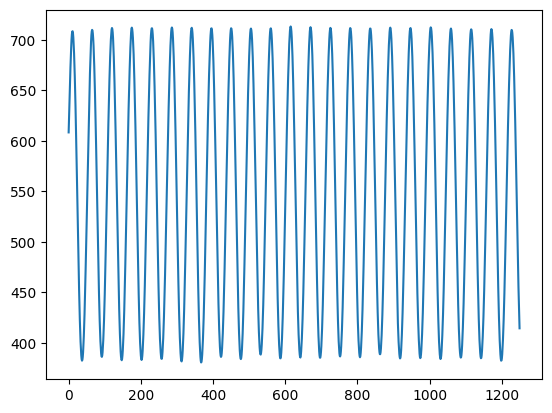

In [16]:
c = ezc3d.c3d("/Users/mathieubourgeois/Desktop/AnalyseIMU/C3DFilesIMU/Sujet_02/Sujet_02_velo_60.c3d", extract_forceplat_data=False)

point_data = c['data']['points']
point_labels = c['parameters']['POINT']['LABELS']
nf_mocap = len(point_data[0][0][:])

Of = np.zeros((nf_mocap, 3))
Of[:, 0] = 0.5 * (point_data[0][find_index("pRightMedMalleolus", point_labels["value"])][:] + point_data[0][find_index("pRightLatMalleolus", point_labels["value"])][:])
Of[:, 1] = 0.5 * (point_data[1][find_index("pRightMedMalleolus", point_labels["value"])][:] + point_data[1][find_index("pRightLatMalleolus", point_labels["value"])][:])
Of[:, 2] = 0.5 * (point_data[2][find_index("pRightMedMalleolus", point_labels["value"])][:] + point_data[2][find_index("pRightLatMalleolus", point_labels["value"])][:])

peaks = find_peaks(Of[:, 2], distance=10)
peaks_to_analyze = peaks[0][:-1][-9:]

plt.plot(Of[:, 2])
print(peaks_to_analyze)